<a href="https://colab.research.google.com/github/deepanandi/python-part1/blob/main/High_Code_COVID_19_Image_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: COVID-19 Image Classification

## Problem Statement

### Context

Covid-19 is a fast-growing disease that affects human health severly. Patients diagonised with this condition suffers from lung infection. The medical community has recently released vaccines which have a slower effect in increasing the immunity. This virus has impacted various countries' human health and financial standing.

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

### Objective

The aim of this project is to Build a Convolutional Neural Network to differentiate an X-ray image of a person affected with covid from that of a healthy person or a person who has viral pneumonia(fever).

### Data Dictionary

- This dataset contains training set images of 3 classes which are converted into numpy arrays.

- The dataset comprises 3 classes:
  - COVID-19: The patient who is effected due to covid.
  - Viral Pneumonia: This is a viral fever which has similar characteristics like fever and cought that of Covid but is not covid.
  
  - Normal- A healthy Person with no symptoms of covid or fever.
- The data file names are:
  - CovidImages.npy
  - CovidLabels.csv

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#pip uninstall tensorflow
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import matplotlib.pyplot as plt                                                                  # Importing matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
#from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

## Loading the dataset

In [2]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the image file of dataset
images = np.load('/content/drive/My Drive/Colab Notebooks/datacsvs/CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datacsvs/CovidLabels.csv')

## Data Overview

### Understand the shape of the dataset

In [9]:
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


There are 251 RGB  images of shape 128 x 128 X 3 each. Each image is an RGB image having 3 channels

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category X-ray images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [10]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                     # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

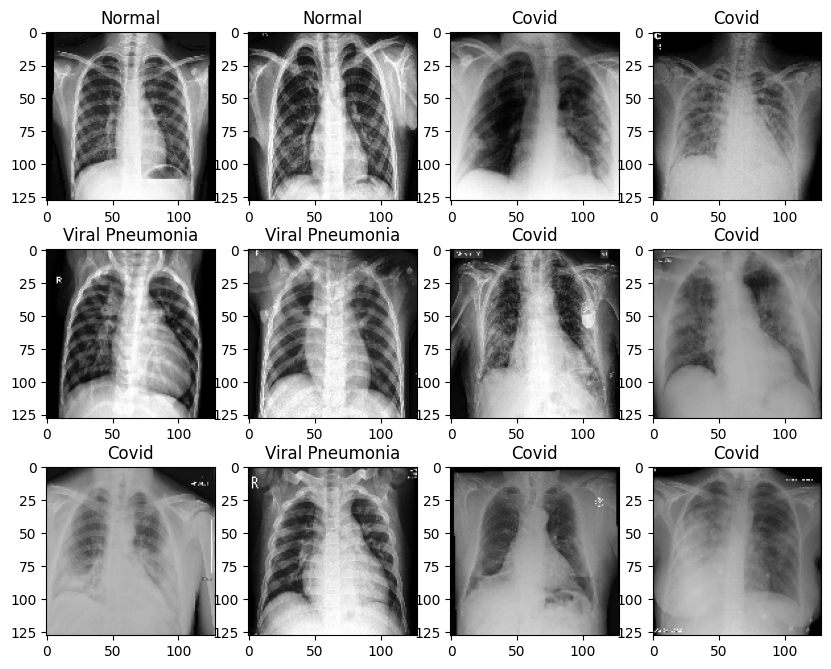

In [11]:
plot_images(images,labels)

In [12]:
type(labels)

pandas.core.frame.DataFrame

([0, 1, 2],
 [Text(0, 0, 'Viral Pneumonia'), Text(1, 0, 'Covid'), Text(2, 0, 'Normal')])

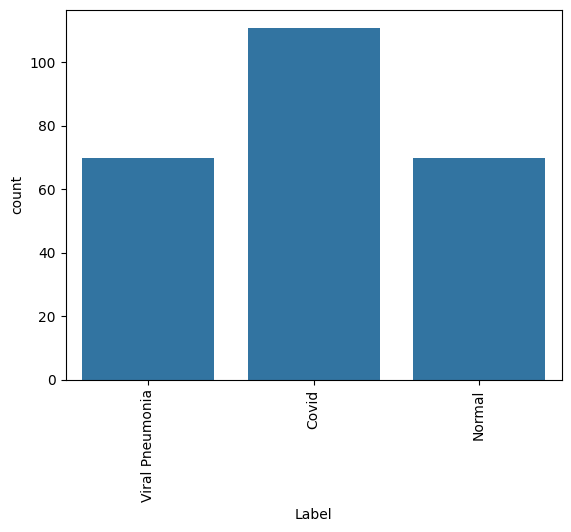

In [13]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Converting the BGR images to RGB images

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [14]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [15]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

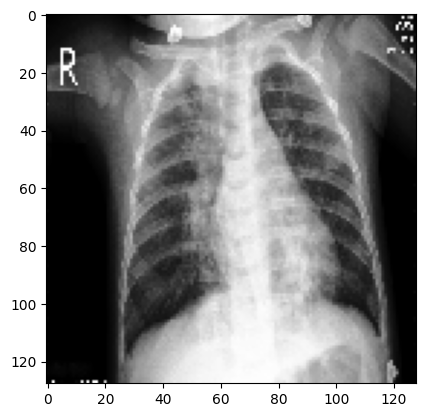

In [16]:
plt.imshow(images[3])

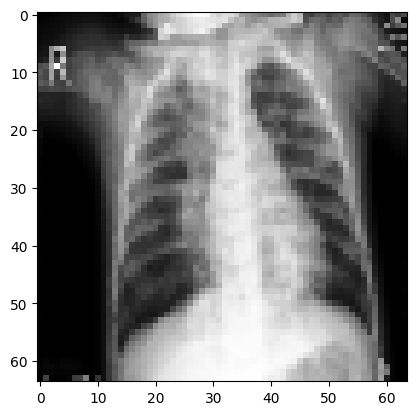

In [17]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels) # Complete the code to split the data with test_size as 0.1


In [19]:
print(X_train.shape,y_train.shape)
#print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(225, 64, 64, 3) (225, 1)
(26, 64, 64, 3) (26, 1)


### Encode the target labels

In [20]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
#y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [21]:
y_train_encoded.shape,y_test_encoded.shape

((225, 3), (26, 3))

### Data Normalization

In [22]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
#X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [24]:
#from tensorflow.keras import backend
backend.clear_session()

In [25]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [34]:
# Intializing a sequential model
model1 = Sequential()                             # Complete the code to intialize a sequential model

# Complete the code to add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Complete the code to add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Complete the code to create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Complete the code to flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Complete the code to add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Complete the code to add the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(3, activation='softmax'))

# Complete the code to use the Adam Optimizer
opt=Adam()
# Complete the code to Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Complete the code to generate the summary of the model
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 32)         

In [35]:
y_train_encoded.shape, X_train_normalized.shape

((225, 3), (225, 64, 64, 3))

In [36]:
# Complete the code to fit the model on train data
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            shuffle=False,
            batch_size=64,
            verbose=1
)

Epoch 1/30
4/4 [==============================] - 4s 257ms/step - loss: 1.1353 - accuracy: 0.4752 - val_loss: 1.1802 - val_accuracy: 0.1739
Epoch 2/30
4/4 [==============================] - 0s 23ms/step - loss: 1.1087 - accuracy: 0.4158 - val_loss: 1.0277 - val_accuracy: 0.5652
Epoch 3/30
4/4 [==============================] - 0s 22ms/step - loss: 1.0187 - accuracy: 0.5594 - val_loss: 0.9709 - val_accuracy: 0.5652
Epoch 4/30
4/4 [==============================] - 0s 22ms/step - loss: 0.9259 - accuracy: 0.6634 - val_loss: 0.8381 - val_accuracy: 0.5652
Epoch 5/30
4/4 [==============================] - 0s 21ms/step - loss: 0.7940 - accuracy: 0.6634 - val_loss: 0.7008 - val_accuracy: 0.6522
Epoch 6/30
4/4 [==============================] - 0s 21ms/step - loss: 0.7009 - accuracy: 0.6782 - val_loss: 0.6813 - val_accuracy: 0.6522
Epoch 7/30
4/4 [==============================] - 0s 21ms/step - loss: 0.6210 - accuracy: 0.7079 - val_loss: 0.6267 - val_accuracy: 0.7391
Epoch 8/30
4/4 [==========

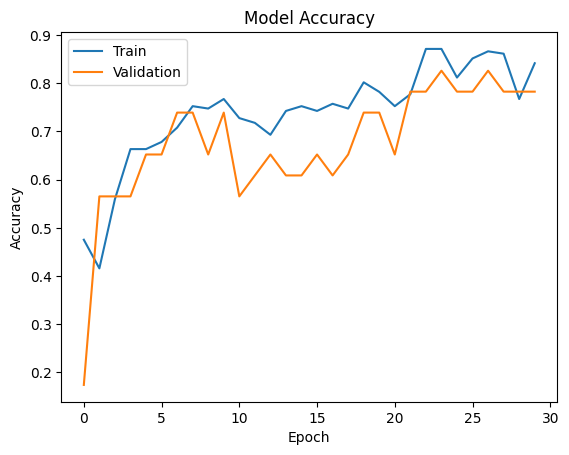

In [37]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    # Complete the code to evaluate the model on test data

1/1 - 0s - loss: 0.2527 - accuracy: 1.0000 - 286ms/epoch - 286ms/step


In [39]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                          # Complete the code to predict the output probabilities

1/1 [==============================] - 0s 102ms/step


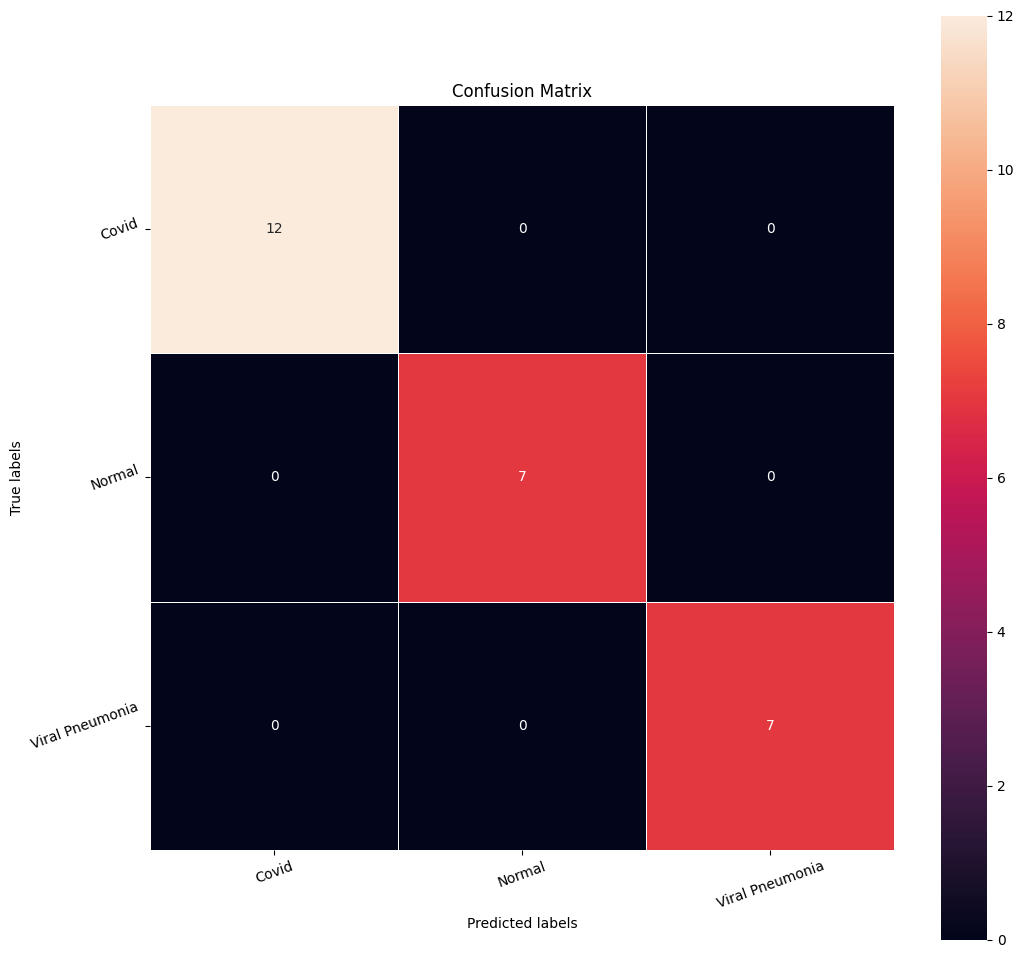

In [40]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)              # Complete the code to plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'],rotation=20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'],rotation=20)
plt.show()

In [42]:
# Plotting the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)


### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [44]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [45]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [46]:
# Intializing a sequential model
model2 = Sequential()

# Complete the code to add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Complete the code to add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Complete the code to add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Complete the code to add the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(3, activation='softmax'))

# Complete the code to initialize Adam Optimimzer
opt=Adam()
# Complete the code to Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [47]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64


history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_test_normalized,y_test_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
3/3 [==============================] - 4s 321ms/step - loss: 1.1138 - accuracy: 0.5714 - val_loss: 1.0196 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 0s 98ms/step - loss: 0.5972 - accuracy: 0.7764 - val_loss: 0.9590 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 0s 98ms/step - loss: 0.5255 - accuracy: 0.7888 - val_loss: 0.9411 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/30
2/3 [===================>..........] - ETA: 0s - loss: 0.5405 - accuracy: 0.7656
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 [==============================] - 0s 79ms/step - loss: 0.5323 - accuracy: 0.7764 - val_loss: 0.9919 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 0s 113ms/step - loss: 0.3662 - accuracy: 0.8571 - val_loss: 1.0243 - val_accuracy: 0.3462 - lr: 5.0000e-04
Epoch 6/30
3/3 [==============================] - 0s 91ms/step - loss: 0.3515

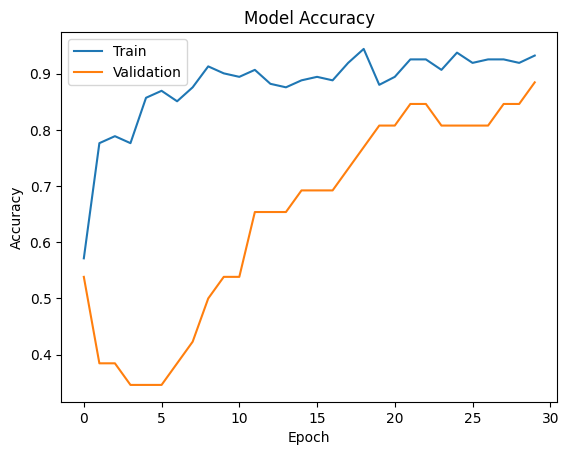

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [49]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

1/1 - 0s - loss: 0.6984 - accuracy: 0.8846 - 25ms/epoch - 25ms/step


In [50]:
# Complete the code to obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

1/1 [==============================] - 0s 79ms/step


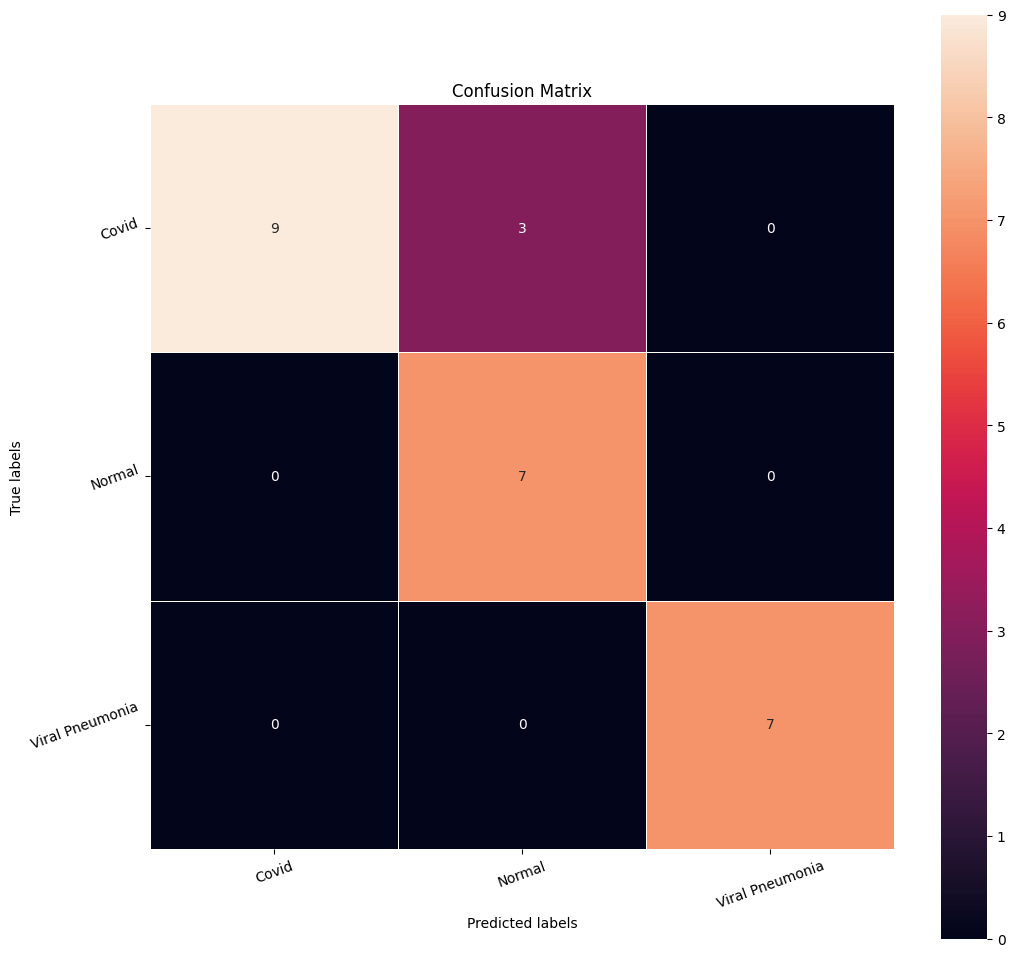

In [51]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'],rotation=20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'],rotation=20)
plt.show()

In [52]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.70      1.00      0.82         7
           2       1.00      1.00      1.00         7

    accuracy                           0.88        26
   macro avg       0.90      0.92      0.89        26
weighted avg       0.92      0.88      0.89        26



## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

### Visualizing the prediction

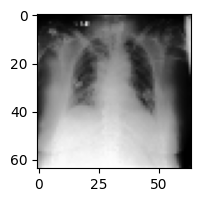

1/1 [==============================] - 0s 184ms/step
Predicted Label ['Covid']
True Label Covid


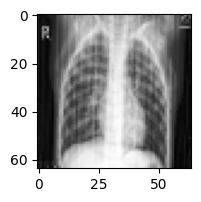

IndexError: index 33 is out of bounds for axis 0 with size 26

In [53]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[10])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[10])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[20],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[20])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])

## Actionable Insights and Business Recommendations

*

_____